# LASSI Data Analysis Pipeline V2
This is an updated attempt to create a pipeline that illustrates how one would take Leica scanner data and produce commands to the Active Surface Manager that would compensate for any detected surface deformations.
The parts of this pipeline that need work we'll mark in <font color='red'>red TODOs</font>. 

In [1]:
%matplotlib notebook

## Step One: Get some Leica data for a reference and signal scan

We are still unclear on how we are going to do this for production.  What we are currently using as input 
are PTX files (human readable) that were produced by Leica employees (using in part at least, the Cyclone software).  
Copies of these files can be in: /home/sandboxes/pmargani/LASSI/data.

According to Brian Elbe, all he did to produce these files was import the data into Cyclone, removed 'unwanted' parts of the image (presumably the ground), then export it to PTX.  Should be easy to replicate. 

The files are further processed by our own Mathematica code that was adapted from some of Fred's work.  
This code does a simple Affine Transform, and filters out things like the header and data that is past a certain 
distance from the scanner.  It can also optionally take a random sample of the PTX data to avoid working with the full data set.

It will write the final output to a file name of your choosing.

The source for this can be found here: /home/sandboxes/pmargani/LASSI/data/LeicaP40demo/Aug2016/myZfit5Part1.m

<font color='red'>TODO:</font> We are currenlty porting this to Python, but are hung up on a question we need answered from Fred.




## Step Two: Smooth this Data

Warning: this is the computationally expensive part!  We've already done this step, which takes about 10 hours for 
each scan, so we highly recommend you don't run this commented code, and instead use the dumps we made of this smoothing to file.

<font color='red'>TODO:</font> we need to find a way to make this processing faster by this summer (2019).


In [2]:
# Don't run this!  For 512x512, using ALL the data (not a random sampling)
# this could take 10 hours for each scan
# from main import *
#n = 512
#fn1 = "data/randomSampleSta10.csv"
#x1, y1, z1 = smoothSpherical(fn1, n)
#fn2 = "data/randomSampleBumpScan14.csv"
#x2, y2, z2 = smoothSpherical(fn2, n)

# instead the smoothed data can be found here:
# fn1 = "data/BumpScan.csv.smoothed.sig.001.all.npz"
# fn = "data/Baseline_STA10_HIGH_METERS.csv.smoothed.sig.001.all.npz"

## Step Three: Fit this data to parabolas
We'll leverage our parabolas module to do the heavy lifting here.
See also the 'Parabolas' and 'Show me the Bumps' Notebooks.

We also have a unit test class, TestParabolas.py, which demonstrates the limits of our parabolas toolbox.


<IPython.core.display.Javascript object>


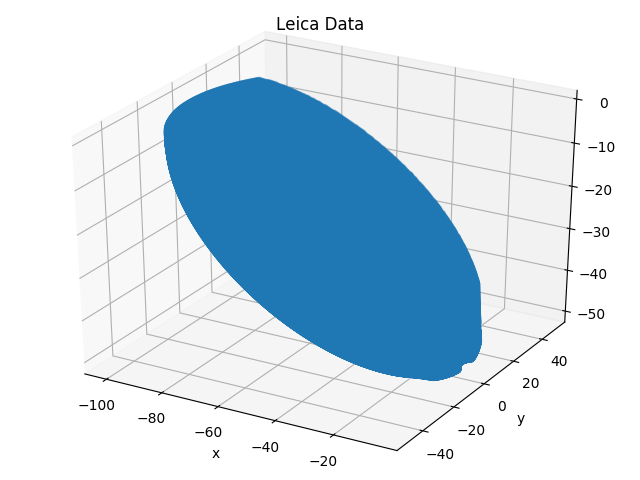

cleaned data fitted with coefficients:  [ 5.74103825e+01  2.83550388e-01 -2.22811412e+00 -4.91790420e+01
  1.52444697e-03 -3.31407039e-02]


<IPython.core.display.Javascript object>


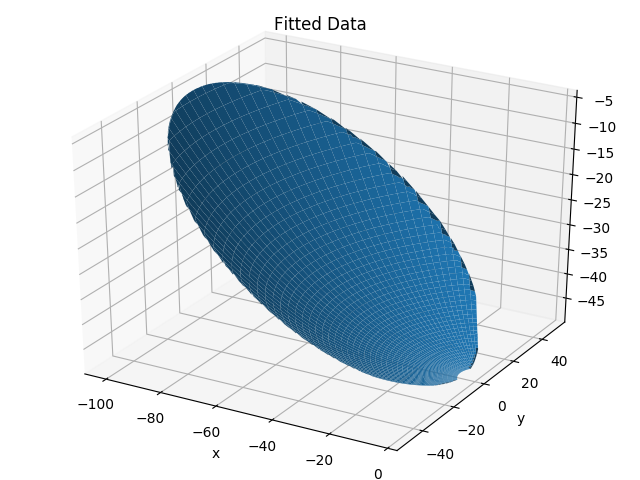

<IPython.core.display.Javascript object>


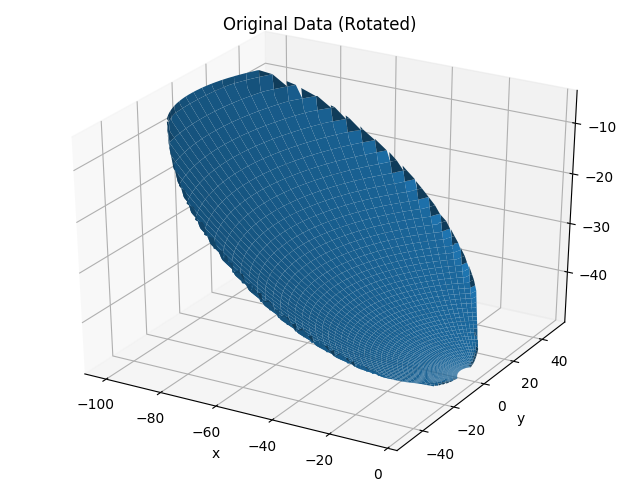

<IPython.core.display.Javascript object>


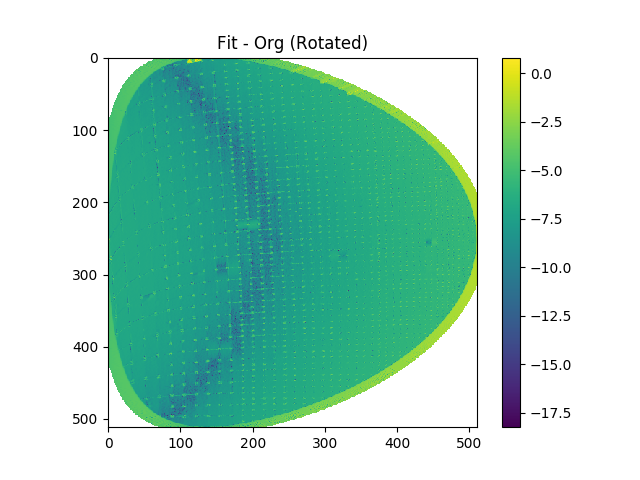

In [3]:
from parabolas import *
fn = "data/Baseline_STA10_HIGH_METERS.csv.smoothed.sig.001.all.npz"
refDiff, refX, refY = fitLeicaScan(fn)

<IPython.core.display.Javascript object>


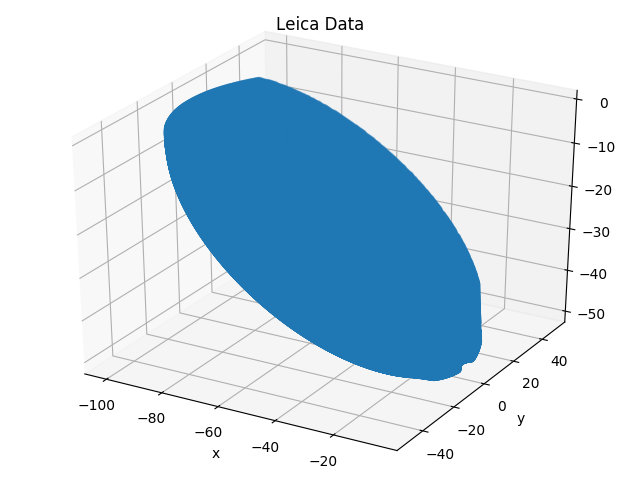

cleaned data fitted with coefficients:  [ 5.74057921e+01  2.87711772e-01 -2.22274546e+00 -4.91783023e+01
  1.43249224e-03 -3.30739453e-02]


<IPython.core.display.Javascript object>


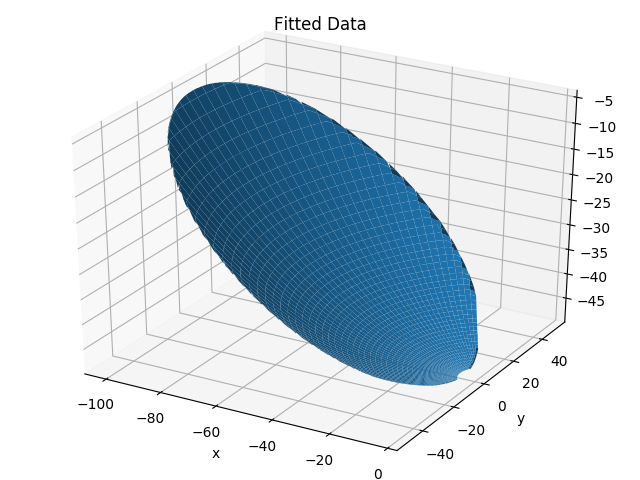

<IPython.core.display.Javascript object>


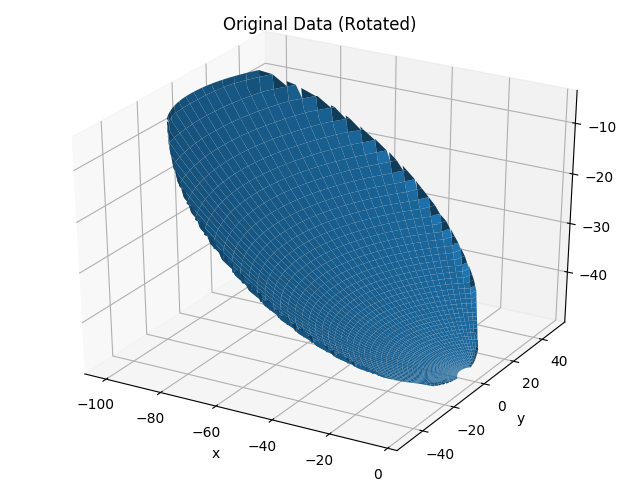

<IPython.core.display.Javascript object>


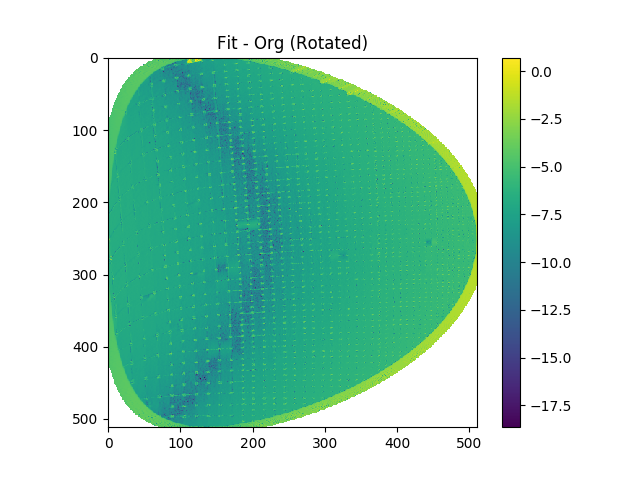

In [46]:
fn = "data/BumpScan.csv.smoothed.sig.001.all.npz"
bumpDiff, bumpX, bumpY = fitLeicaScan(fn)

## Step Four: Regrid the data to both be in the same evenly spaced x, y
Both so that both scans are in the same x, y space, and also in preparation for fitting zernikes to the results, we need to regrid our scans.  They were evenly spaced in spherical coordinated, but are now unevenly spaced in x, y, which is why the images above look like guitar picks and not dishes.  This is the problem we are fixing in this step.

In [53]:
# Don't run this code now: it takes about 20 minutes for each scan!
# bumpXs, bumpYs, bumpDiffs = smoothXYZDask(bumpX, bumpY, bumpDiff, 512, sigX=0.1, sigY=0.1)
# refXs, refYs, refDiffs = smoothXYZDask(refX, refY, refDiff, 512, sigX=0.1, sigY=0.1)

# instead we can load the saved results
refDiffs = np.load("refDiffsSmoothed.npy")
refXs = np.load("refXsSmoothed.npy")
refYs = np.load("refYsSmoothed.npy")
bumpXs = np.load("bumpXsSmoothed.npy")
bumpYs = np.load("bumpYsSmoothed.npy")
bumpDiffs = np.load("bumpDiffsSmoothed.npy")

<IPython.core.display.Javascript object>


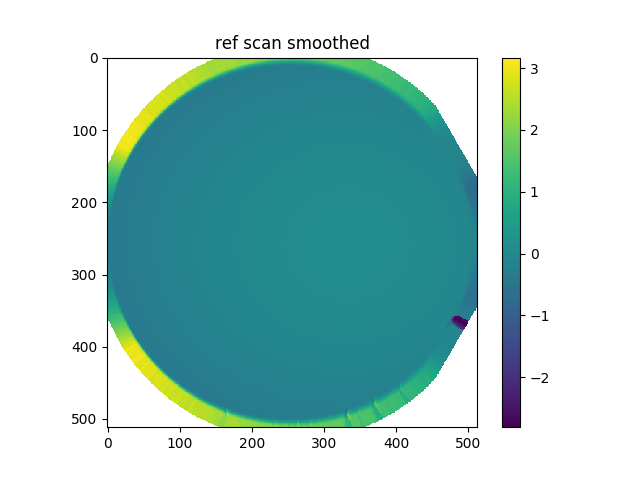

In [54]:
imagePlot(refDiffs, "ref scan smoothed")

<IPython.core.display.Javascript object>


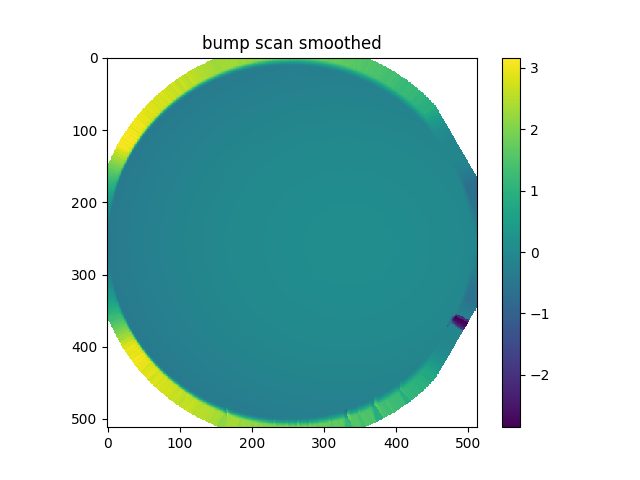

In [55]:
imagePlot(bumpDiffs, "bump scan smoothed")

These images don't tell us much, but if we were to smooth the log of the difference of one of these scans, we'll see a familiar image:

![refDiffLog](refDiffLogRegridded512.png)

## Step Five: Find the Deformations
Also known as, 'Show me the Bumps'.  This step is conceptually simple: we just find the difference between our reference and signal scan.  We break it out in a separate step here for dramatic affect.

<IPython.core.display.Javascript object>


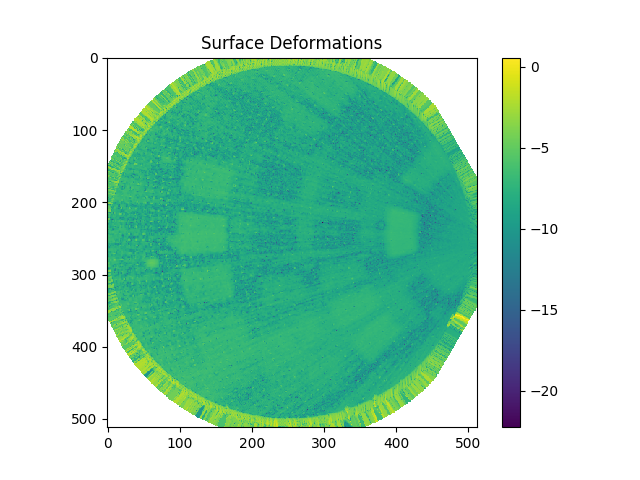

In [56]:
diffData = refDiffs - bumpDiffs
diffDataLog = np.log(np.abs(diffData))
imagePlot(diffDataLog, "Surface Deformations")

Step five and a half: open some beers.

## Step Six:  Fit Zernikes to this surface
This is identical to what we did in the first version of our pipeline.  But note, that we're still not sure that we want to do this on this data: we probably need put this image on a unit circle?

<font color='red'>TODO:</font> Determine what else might need to be done to image before fitting zernikes.

<IPython.core.display.Javascript object>


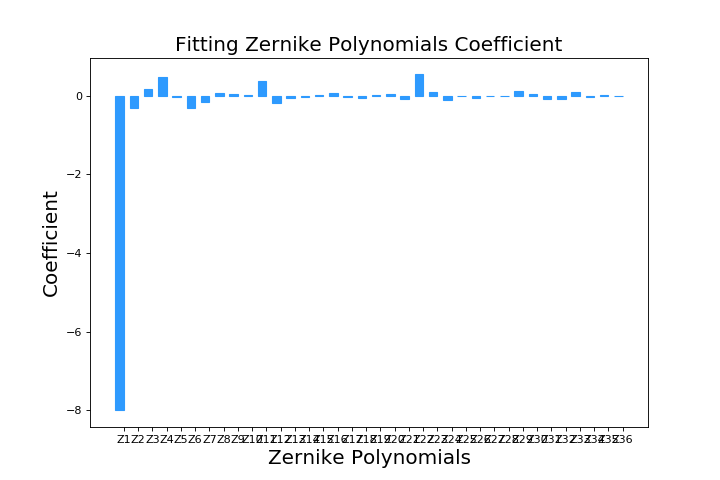

<IPython.core.display.Javascript object>


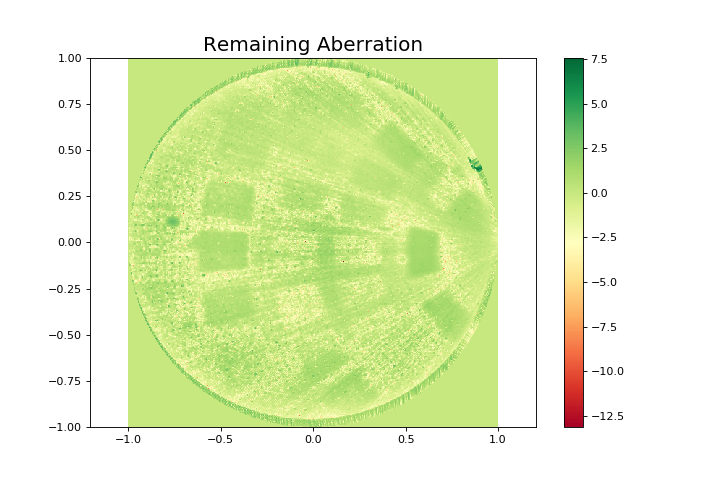

                            Zernike Polynomials List                              
----------------------------------------------------------------------------------
|   Z1  |   Z2  |   Z3  |   Z4  |   Z5  |   Z6  |   Z7  |   Z8  |   Z9  |  Z10  |
----------------------------------------------------------------------------------
| 0.000 |-0.306 | 0.171 | 0.468 |-0.028 |-0.309 |-0.153 | 0.072 | 0.053 | 0.027 |
----------------------------------------------------------------------------------
|  Z11  |  Z12  |  Z13  |  Z14  |  Z15  |  Z16  |  Z17  |  Z18  |  Z19  |  Z20  |
----------------------------------------------------------------------------------
| 0.365 |-0.182 |-0.067 |-0.037 | 0.015 | 0.074 |-0.025 |-0.053 | 0.023 | 0.030 |
----------------------------------------------------------------------------------
|  Z21  |  Z22  |  Z23  |  Z24  |  Z25  |  Z26  |  Z27  |  Z28  |  Z29  |  Z30  |
----------------------------------------------------------------------------------
|-0.097 |

<IPython.core.display.Javascript object>


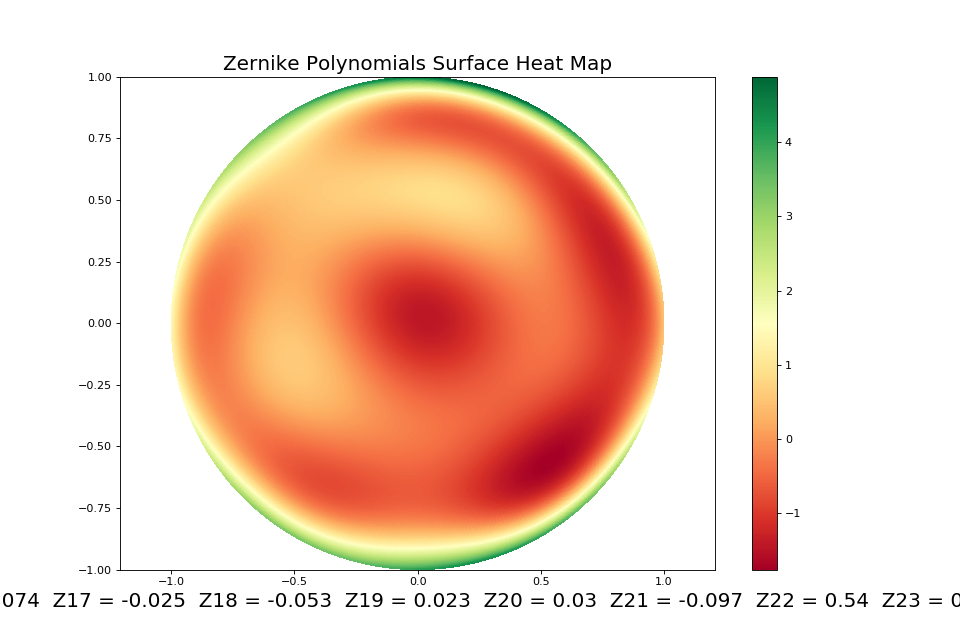

Z2 =  -0.306 Z11 x Tilt
Z3 =  0.171 Z11 y Tilt
Z4 =  0.468 Z20 Defocus
Z5 =  -0.028 Z22 Primary Astigmatism at 45
Z6 =  -0.309 Z22 Primary Astigmatism at 0
Z7 =  -0.153 Z31 Primary y Coma
Z8 =  0.072 Z31 Primary x Coma
Z9 =  0.053 Z33 y Trefoil
Z10 =  0.027 Z33 x Trefoil
Z11 =  0.365 Z40 Primary Spherical
Z12 =  -0.182 Z42 Secondary Astigmatism at 0
Z13 =  -0.067 Z42 Secondary Astigmatism at 45
Z14 =  -0.037 Z44 x Tetrafoil
Z15 =  0.015 Z44 y Tetrafoil
Z16 =  0.074 Z51 Secondary x Coma
Z17 =  -0.025 Z51 Secondary y Coma
Z18 =  -0.053 Z53 Secondary x Trefoil
Z19 =  0.023 Z53 Secondary y Trefoil
Z20 =  0.03 Z55 x Pentafoil
Z21 =  -0.097 Z55 y Pentafoil
Z22 =  0.54 Z60 Secondary Spherical
Z23 =  0.08 Z62 Tertiary Astigmatism at 45
Z24 =  -0.1 Z62 Tertiary Astigmatism at 0
Z25 =  -0.021 Z64 Secondary x Trefoil
Z26 =  -0.057 Z64 Secondary y Trefoil
Z27 =  -0.014 Z66 Hexafoil Y
Z28 =  -0.014 Z66 Hexafoil X
Z29 =  0.118 Z71 Tertiary y Coma
Z30 =  0.048 Z71 Tertiary x Coma
Z31 =  -0.08 Z73 Ter

In [57]:
import opticspy
from copy import copy
import numpy as np

# replace NaNs with zeros
diffDataOrg = copy(diffData)
diffDataLog[np.isnan(diffDataLog)] = 0.

# find the first 12 Zernike terms
numZsFit = 36
fitlist,C1 = opticspy.zernike.fitting(diffDataLog,
                                      numZsFit,
                                      remain2D=1,
                                      barchart=1)
print "fitlist: ", fitlist
C1.listcoefficient()
C1.zernikemap()

## Step Seven: Convert the coefficients from Noll to ANSI
Recall that opticspy works in Noll notation, while the Active Surface Manager seems to work in a modified version of ANSI (offset by one, phase rotated by 90 degrees).
Whether this is the only conversion needed to be done is another remaining open question.


In [58]:
from zernikeIndexing import noll2asAnsi, printZs
# why does the fitlist start with a zero? for Z0??  Anyways, avoid it
nollZs = fitlist[1:(numZsFit+1)]
asAnsiZs = noll2asAnsi(nollZs)
print "nolZs"
printZs(nollZs)
print "active surface Zs"
printZs(asAnsiZs)

nolZs
[0]
[-0.306, 0.171]
[0.468, -0.028, -0.309]
[-0.153, 0.072, 0.053, 0.027]
[0.365, -0.182, -0.067, -0.037, 0.015]
[0.074, -0.025, -0.053, 0.023, 0.03, -0.097]
[0.54, 0.08, -0.1, -0.021, -0.057, -0.014, -0.014]
[0.118, 0.048, -0.08, -0.078, 0.09, -0.027, 0.013, -0.02]
active surface Zs
[0]
[-0.306, 0.171]
[-0.309, 0.468, -0.028]
[0.027, 0.072, -0.153, 0.053]
[-0.037, -0.182, 0.365, -0.067, 0.015]
[0.03, -0.053, 0.074, -0.025, 0.023, -0.097]
[-0.014, -0.057, -0.1, 0.54, 0.08, -0.021, -0.014]
[-0.02, -0.027, -0.078, 0.048, 0.118, -0.08, 0.09, 0.013]


## Step Eight: Send these Coefficients to the Active Surface Manager

The Active Surface Manager has the zernike_coeff parameter (indexes 1 through N).  When these are set, the manager can use them to compute the displacement of each individual actuator.

However, one has to have everything setup correctly and have the right permissions, so we won't simply call it from here.  Instead, here's the instructions:
   * save asAnsiZs to numpy file
   * decide which telescope you want to use (real, sim?)
   * use the new ActiveSurfaceDevice.py here: /home/sandboxes/pmargani/sparrow/master3/sparrow/gbt/api/ygor/src
   * python ActiveSurfaceDevice.py <path to numpy file>
